# Station Priority for Infrastructure Bill Funds

Using the publicly available MTA Turnstyle data, I will determine which stations receive the most traffic. Using the MTA station maintenance and malfunction logs I will further narrow the list.

In [2]:
import pandas as pd
import os
import datetime as dt
from sqlalchemy import create_engine

In [3]:
print(os.getcwd())

/home/jtaz/Documents/MTA_turnstile/Project


In [4]:
'''engine is the database, url is the rbdmns you are using and 3 slashes for relative file path. this works since
file is in the working directory'''
engine = create_engine('sqlite:///mta_data.db')
engine.table_names()

/tmp/ipykernel_2129/823041238.py:4: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['mta_data']

In [5]:
mta_df_v2 = pd.read_sql('SELECT * FROM mta_data;', engine)

In [6]:
mta_df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983186 entries, 0 to 3983185
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 334.3+ MB


In [7]:
mta_df = mta_df_v2
#mta_df = pd.read_csv('mta_datav2.csv')
mta_df.info()
'''import .csv and store in dataframe. execute.info to get dtypes, rows, column names, etc'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983186 entries, 0 to 3983185
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 334.3+ MB


'import .csv and store in dataframe. execute.info to get dtypes, rows, column names, etc'

In [8]:
mta_df.head()
'''.head to see first 5 rows and get a feel for the data'''

'.head to see first 5 rows and get a feel for the data'

In [9]:
mta_df.columns
'''check columns for extra spaces or irregularities requiring cleaning or strip'''

'check columns for extra spaces or irregularities requiring cleaning or strip'

In [10]:
'''create new column "DATE_TIME" to store the merging of "DATE" and "TIME" columns. use to_datetime to
convert to datetime dtype.'''
mta_df['DATE_TIME'] = pd.to_datetime(mta_df.DATE + ' ' + mta_df.TIME, infer_datetime_format = True)
mta_df.dtypes

C/A                  object
UNIT                 object
SCP                  object
STATION              object
LINENAME             object
DIVISION             object
DATE                 object
TIME                 object
DESC                 object
ENTRIES               int64
EXITS                 int64
DATE_TIME    datetime64[ns]
dtype: object

In [11]:
'''delete DATE and TIME columns since they are no longer needed'''
mta_df1 = mta_df
mta_df = mta_df.drop(['DATE', 'TIME'], axis = 1)
mta_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DESC',
       'ENTRIES', 'EXITS', 'DATE_TIME'],
      dtype='object')

In [12]:
'''check for duplicate entries'''
'''groupby sorts the entries by turnstyle and time and .count() gives the number of rows for each entry.
it should only be 1 per entry because of how we grouped it. reset_index resets the index for the new grouped order.
sort_values with the largest on top so any redundancy counts are visible with .head()'''
(mta_df
    .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'])
    .ENTRIES.count()
    .reset_index()
    .sort_values('ENTRIES', ascending = False)).head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
3951720,S101,R070,00-00-02,ST. GEORGE,2021-09-29 12:00:00,2
3582043,R514,R094,00-05-00,ASTORIA BLVD,2021-07-22 12:00:00,2
3951722,S101,R070,00-00-02,ST. GEORGE,2021-09-29 20:00:00,2
3951721,S101,R070,00-00-02,ST. GEORGE,2021-09-29 16:00:00,2
1078379,N071,R013,00-00-00,34 ST-PENN STA,2021-04-08 08:00:00,2


In [13]:
'''Use a mask to target a specific entry with redundancies'''
mask = ((mta_df['C/A'] == 'S101') &
(mta_df['UNIT'] == 'R070') &
(mta_df['SCP'] == '00-00-02') &
(mta_df['STATION'] == 'ST. GEORGE') &
(mta_df['DATE_TIME'].dt.date == dt.datetime(2021, 10, 3).date()))

mta_df[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,DATE_TIME
837908,S101,R070,00-00-02,ST. GEORGE,1,SRT,RECOVR AUD,1217256,140,2021-10-03 00:00:00
837909,S101,R070,00-00-02,ST. GEORGE,1,SRT,REGULAR,1217257,140,2021-10-03 04:00:00
837910,S101,R070,00-00-02,ST. GEORGE,1,SRT,REGULAR,1217265,140,2021-10-03 08:00:00
837911,S101,R070,00-00-02,ST. GEORGE,1,SRT,RECOVR AUD,1400965,324,2021-10-03 08:00:00
837912,S101,R070,00-00-02,ST. GEORGE,1,SRT,REGULAR,1217284,140,2021-10-03 12:00:00


In [14]:
'''delete the duplicate entries caused by the recovery audits'''
'''first sort mta_df by each turnstyle and time, and store in mta_df by setting inpace = True'''
mta_df.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'], inplace = True, ascending = True)

'''use drop.duplicates to delete duplicates caused by audits'''
mta_df.drop_duplicates(subset=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'], inplace = True)

In [15]:
'''check that duplicates were deleted'''
(mta_df
    .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'])
    .ENTRIES.count()
    .reset_index()
    .sort_values('ENTRIES', ascending = False)).head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2020-12-26 03:00:00,1
2655432,R138,R293,00-05-01,34 ST-PENN STA,2021-04-03 14:00:00,1
2655404,R138,R293,00-05-01,34 ST-PENN STA,2021-03-29 22:00:00,1
2655405,R138,R293,00-05-01,34 ST-PENN STA,2021-03-30 02:00:00,1
2655406,R138,R293,00-05-01,34 ST-PENN STA,2021-03-30 06:00:00,1


In [16]:
'''drop exits and description columns, we only need entries to answer our question'''
mta_df = mta_df.drop(['DESC', 'EXITS'], axis=1, errors='ignore')
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,ENTRIES,DATE_TIME
3772753,A002,R051,02-00-00,59 ST,NQR456W,BMT,7508509,2020-12-26 03:00:00
3772754,A002,R051,02-00-00,59 ST,NQR456W,BMT,7508511,2020-12-26 07:00:00
3772755,A002,R051,02-00-00,59 ST,NQR456W,BMT,7508531,2020-12-26 11:00:00
3772756,A002,R051,02-00-00,59 ST,NQR456W,BMT,7508610,2020-12-26 15:00:00
3772757,A002,R051,02-00-00,59 ST,NQR456W,BMT,7508767,2020-12-26 19:00:00


In [17]:
'''reduce dataframe to just one data pull per day'''
mta_daily = mta_df[mta_df.DATE_TIME.dt.hour == 0]
mta_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,ENTRIES,DATE_TIME
2725878,A002,R051,02-00-00,59 ST,NQR456W,BMT,7550517,2021-03-27
2725884,A002,R051,02-00-00,59 ST,NQR456W,BMT,7550517,2021-03-28
2725890,A002,R051,02-00-00,59 ST,NQR456W,BMT,7550709,2021-03-29
2725896,A002,R051,02-00-00,59 ST,NQR456W,BMT,7551243,2021-03-30
2725902,A002,R051,02-00-00,59 ST,NQR456W,BMT,7551789,2021-03-31


In [18]:
mta_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331882 entries, 2725878 to 3143855
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   C/A        331882 non-null  object        
 1   UNIT       331882 non-null  object        
 2   SCP        331882 non-null  object        
 3   STATION    331882 non-null  object        
 4   LINENAME   331882 non-null  object        
 5   DIVISION   331882 non-null  object        
 6   ENTRIES    331882 non-null  int64         
 7   DATE_TIME  331882 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 22.8+ MB


In [19]:
'''in order to calculate daily entries, i create 2 new columns for prev date and prev entries.
group by each style, shift the DATE and ENTRIES columns down 1 row'''
mta_daily[['PREV_DATE','PREV_ENTRIES']] = (mta_daily
                                              .groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DATE_TIME','ENTRIES']
                                               .apply(lambda grp: grp.shift(1))
                                          )
mta_daily.head()

/tmp/ipykernel_2129/1256431989.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_daily[['PREV_DATE','PREV_ENTRIES']] = (mta_daily
/home/jtaz/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,ENTRIES,DATE_TIME,PREV_DATE,PREV_ENTRIES
2725878,A002,R051,02-00-00,59 ST,NQR456W,BMT,7550517,2021-03-27,NaT,NaN
2725884,A002,R051,02-00-00,59 ST,NQR456W,BMT,7550517,2021-03-28,2021-03-27,7550517.0
2725890,A002,R051,02-00-00,59 ST,NQR456W,BMT,7550709,2021-03-29,2021-03-28,7550517.0
2725896,A002,R051,02-00-00,59 ST,NQR456W,BMT,7551243,2021-03-30,2021-03-29,7550709.0
2725902,A002,R051,02-00-00,59 ST,NQR456W,BMT,7551789,2021-03-31,2021-03-30,7551243.0


In [20]:
'''identify if any of the counters are working in reverse or if they reset after reaching a certain number.
Group by station and take .size'''
(mta_daily[mta_daily['ENTRIES'] < mta_daily['PREV_ENTRIES']]
     .groupby(['C/A', 'UNIT', 'SCP', 'STATION'])
     .size())

C/A   UNIT  SCP       STATION        
A011  R080  01-03-00  57 ST-7 AV         97
            01-03-03  57 ST-7 AV          1
            01-03-04  57 ST-7 AV          1
A013  R081  01-03-00  49 ST               1
            01-06-01  49 ST               2
                                         ..
R622  R123  00-00-00  FRANKLIN AV        97
R633  R068  00-00-01  VAN SICLEN AV       1
R730  R431  00-00-04  EASTCHSTER/DYRE    34
S101  R070  00-00-02  ST. GEORGE          2
            00-00-04  ST. GEORGE          1
Length: 290, dtype: int64

In [21]:
'''METIS MTA_EXERCISE_2 provided the idea that counters might be reset and the need to account for it in this way '''
'''alter daily function to deal with possible counter resets'''
def daily1(row, maxcnt):
    #get count by subtracting today count from yesterday count
    cnt = row['ENTRIES'] - row['PREV_ENTRIES']
    #if count is negative, it's because the counter is counting down, diff is still valid
    if cnt < 0:
        cnt = -1*cnt
    #if daily count exceeds 1,000,000 it might be because the counter was reset, set counter to min of two values
    if cnt > maxcnt:
        cnt = min(row['ENTRIES'], row['PREV_ENTRIES'])
    if cnt > maxcnt:
        cnt = 0
    return cnt
mta_daily['DAILY_ENT'] = mta_daily.apply(daily1, axis = 1, maxcnt = 200000)
mta_daily.head(10)

/tmp/ipykernel_2129/2141046687.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_daily['DAILY_ENT'] = mta_daily.apply(daily1, axis = 1, maxcnt = 200000)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,ENTRIES,DATE_TIME,PREV_DATE,PREV_ENTRIES,DAILY_ENT
2725878,A002,R051,02-00-00,59 ST,NQR456W,BMT,7550517,2021-03-27,NaT,NaN,NaN
2725884,A002,R051,02-00-00,59 ST,NQR456W,BMT,7550517,2021-03-28,2021-03-27,7550517.0,0.0
2725890,A002,R051,02-00-00,59 ST,NQR456W,BMT,7550709,2021-03-29,2021-03-28,7550517.0,192.0
2725896,A002,R051,02-00-00,59 ST,NQR456W,BMT,7551243,2021-03-30,2021-03-29,7550709.0,534.0
2725902,A002,R051,02-00-00,59 ST,NQR456W,BMT,7551789,2021-03-31,2021-03-30,7551243.0,546.0
2725908,A002,R051,02-00-00,59 ST,NQR456W,BMT,7552051,2021-04-01,2021-03-31,7551789.0,262.0
2725914,A002,R051,02-00-00,59 ST,NQR456W,BMT,7552051,2021-04-02,2021-04-01,7552051.0,0.0
2516312,A002,R051,02-00-00,59 ST,NQR456W,BMT,7552051,2021-04-03,2021-04-02,7552051.0,0.0
2516318,A002,R051,02-00-00,59 ST,NQR456W,BMT,7552051,2021-04-04,2021-04-03,7552051.0,0.0
2516324,A002,R051,02-00-00,59 ST,NQR456W,BMT,7552051,2021-04-05,2021-04-04,7552051.0,0.0


In [22]:
mta_final = mta_daily.drop(['DIVISION','ENTRIES','PREV_DATE','PREV_ENTRIES'], axis=1)
mta_final.head(20)

,C/A,UNIT,SCP,STATION,LINENAME,DATE_TIME,DAILY_ENT
2725878,A002,R051,02-00-00,59 ST,NQR456W,2021-03-27,NaN
2725884,A002,R051,02-00-00,59 ST,NQR456W,2021-03-28,0.0
2725890,A002,R051,02-00-00,59 ST,NQR456W,2021-03-29,192.0
2725896,A002,R051,02-00-00,59 ST,NQR456W,2021-03-30,534.0
2725902,A002,R051,02-00-00,59 ST,NQR456W,2021-03-31,546.0
2725908,A002,R051,02-00-00,59 ST,NQR456W,2021-04-01,262.0
2725914,A002,R051,02-00-00,59 ST,NQR456W,2021-04-02,0.0
2516312,A002,R051,02-00-00,59 ST,NQR456W,2021-04-03,0.0
2516318,A002,R051,02-00-00,59 ST,NQR456W,2021-04-04,0.0
2516324,A002,R051,02-00-00,59 ST,NQR456W,2021-04-05,0.0


In [23]:
mta_final = mta_final.dropna(subset=['DAILY_ENT'])
#drop empty daily count rows

In [24]:
'''get station total by summing all the turnstyles'''
mta_final = mta_final.groupby(['STATION', 'DATE_TIME'])['DAILY_ENT'].sum().reset_index()
mta_final.head()

,STATION,DATE_TIME,DAILY_ENT
0,1 AV,2021-03-28,5499.0
1,1 AV,2021-03-29,3347.0
2,1 AV,2021-03-30,5949.0
3,1 AV,2021-03-31,6741.0
4,1 AV,2021-04-01,6438.0


In [25]:
'''create 4 separate dataframes, one for each month of data'''
jan_mask = mta_final.DATE_TIME.dt.month == 1
apr_mask = mta_final.DATE_TIME.dt.month == 4
jul_mask = mta_final.DATE_TIME.dt.month == 7
oct_mask = mta_final.DATE_TIME.dt.month == 10

mta_jan = mta_final[jan_mask]
mta_apr = mta_final[apr_mask]
mta_jul = mta_final[jul_mask]
mta_oct = mta_final[oct_mask]

mta_jan.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7480 entries, 102 to 36696
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   STATION    7480 non-null   object        
 1   DATE_TIME  7480 non-null   datetime64[ns]
 2   DAILY_ENT  7480 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 233.8+ KB


In [26]:
mta_jan_tot = (mta_jan.groupby('STATION')[['DAILY_ENT']].sum()
               .sort_values(by=['DAILY_ENT'], ascending = False)
               .reset_index())
mta_jan_tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STATION    198 non-null    object 
 1   DAILY_ENT  198 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.2+ KB


In [27]:
mta_jan_tot.drop(mta_jan_tot.index[10:], inplace = True)
mta_jan_tot.head(10)

,STATION,DAILY_ENT
0,PATH NEW WTC,526615.0
1,14 ST-UNION SQ,506592.0
2,CANAL ST,460873.0
3,96 ST,376482.0
4,125 ST,311902.0
5,GRD CNTRL-42 ST,278546.0
6,FULTON ST,260015.0
7,116 ST,249718.0
8,72 ST,234726.0
9,JOURNAL SQUARE,222326.0


In [28]:
import matplotlib.pyplot as plt

In [29]:
sm_fnt = 10
md_fnt = 12
bg_fnt = 20

plt.rc('font', size = sm_fnt)
plt.rc('axes', titlesize = sm_fnt)
plt.rc('axes', labelsize = md_fnt)
plt.rc('figure', titlesize = bg_fnt)

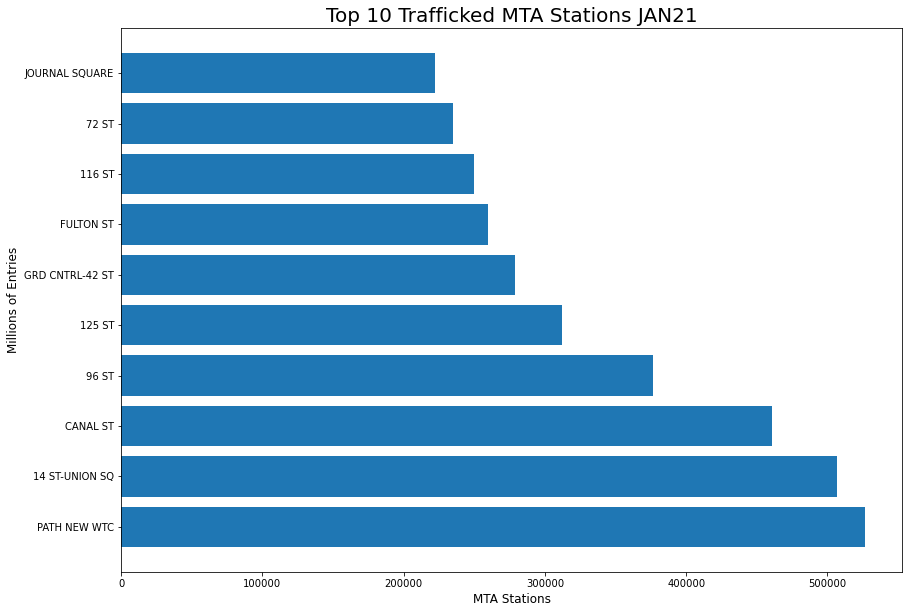

In [30]:
plt.figure(figsize = (14,10))
plt.barh(mta_jan_tot['STATION'], mta_jan_tot['DAILY_ENT'])
plt.title('Top 10 Trafficked MTA Stations JAN21', fontsize = 20)
plt.xlabel('MTA Stations')
plt.ylabel('Millions of Entries')
plt.savefig('JAN_MTA_traffic.jpg')

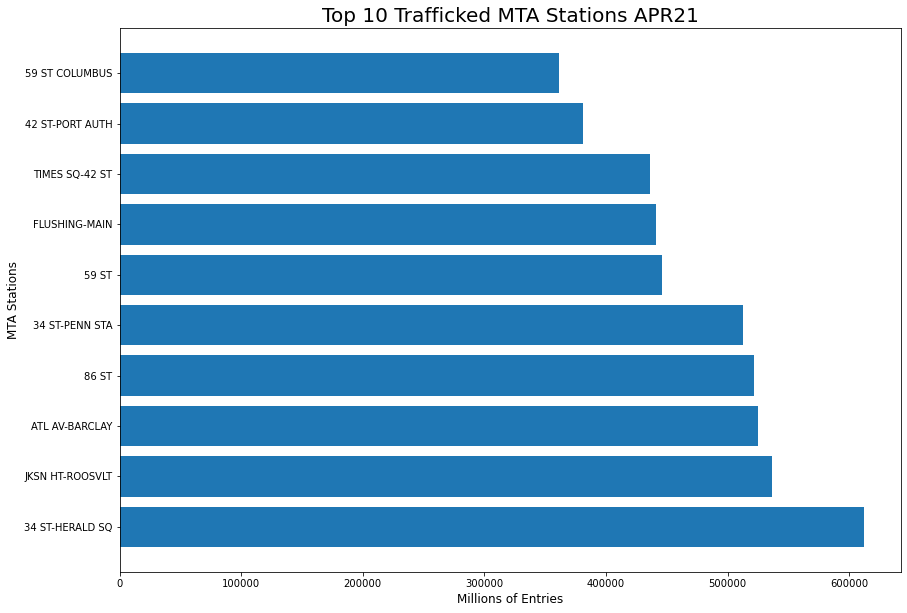

In [31]:
mta_apr_tot = (mta_apr.groupby('STATION')[['DAILY_ENT']].sum()
               .sort_values(by=['DAILY_ENT'], ascending = False)
               .reset_index())
mta_apr_tot.drop(mta_apr_tot.index[10:], inplace = True)

plt.figure(figsize = (14,10))
plt.barh(mta_apr_tot['STATION'], mta_apr_tot['DAILY_ENT'])
plt.title('Top 10 Trafficked MTA Stations APR21', fontsize = 20)
plt.ylabel('MTA Stations')
plt.xlabel('Millions of Entries')
plt.savefig('APR_MTA_traffic.jpg')

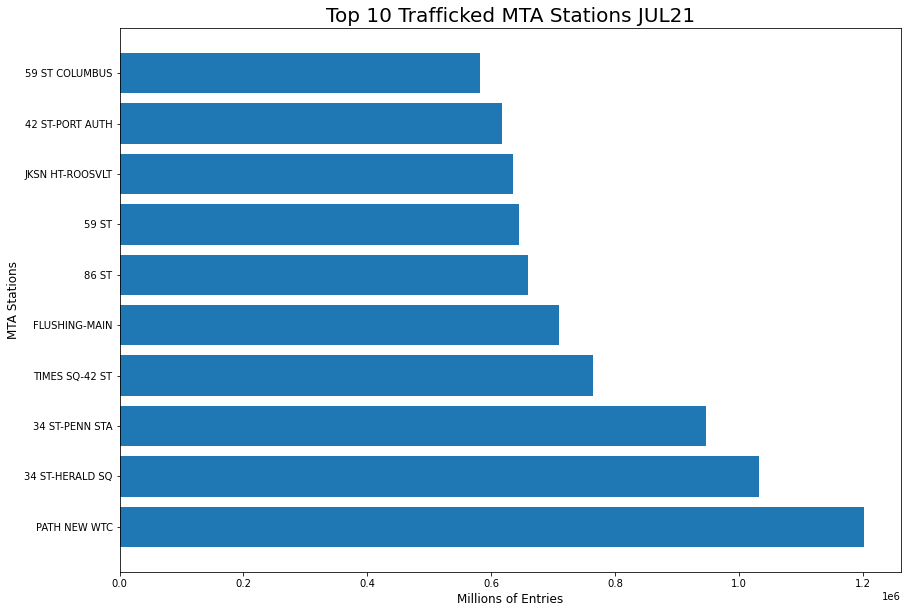

In [32]:
mta_jul_tot = (mta_jul.groupby('STATION')[['DAILY_ENT']].sum()
               .sort_values(by=['DAILY_ENT'], ascending = False)
               .reset_index())
mta_jul_tot.drop(mta_jul_tot.index[10:], inplace = True)


plt.figure(figsize = (14,10))
plt.barh(mta_jul_tot['STATION'], mta_jul_tot['DAILY_ENT'])
plt.title('Top 10 Trafficked MTA Stations JUL21', fontsize = 20)
plt.ylabel('MTA Stations')
plt.xlabel('Millions of Entries')
plt.savefig('JUL_MTA_traffic.jpg')

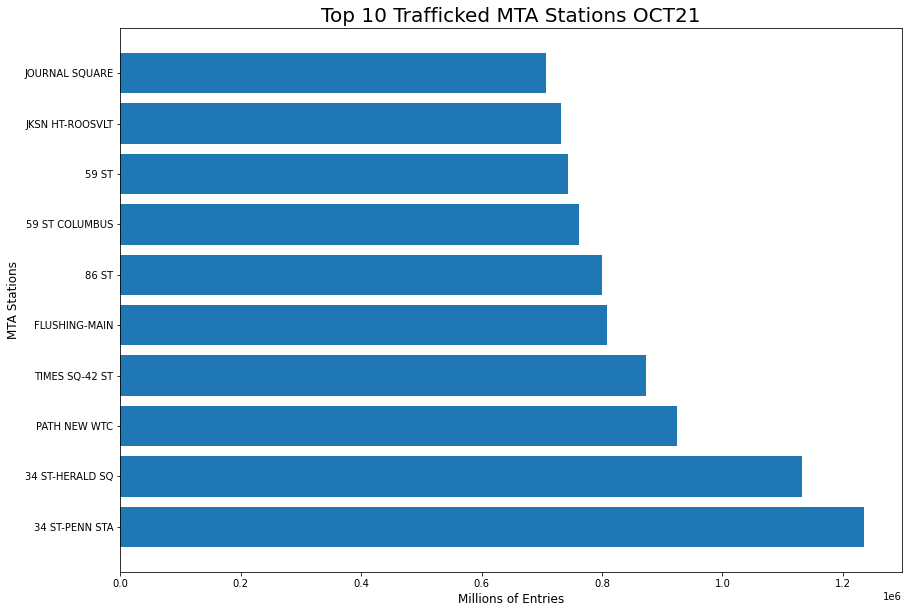

In [33]:
mta_oct_tot = (mta_oct.groupby('STATION')[['DAILY_ENT']].sum()
               .sort_values(by=['DAILY_ENT'], ascending = False)
               .reset_index())
mta_oct_tot.drop(mta_oct_tot.index[10:], inplace = True)

plt.figure(figsize = (14,10))
plt.barh(mta_oct_tot['STATION'], mta_oct_tot['DAILY_ENT'])
plt.title('Top 10 Trafficked MTA Stations OCT21', fontsize = 20)
plt.ylabel('MTA Stations')
plt.xlabel('Millions of Entries')
plt.savefig('OCT_MTA_traffic.jpg')

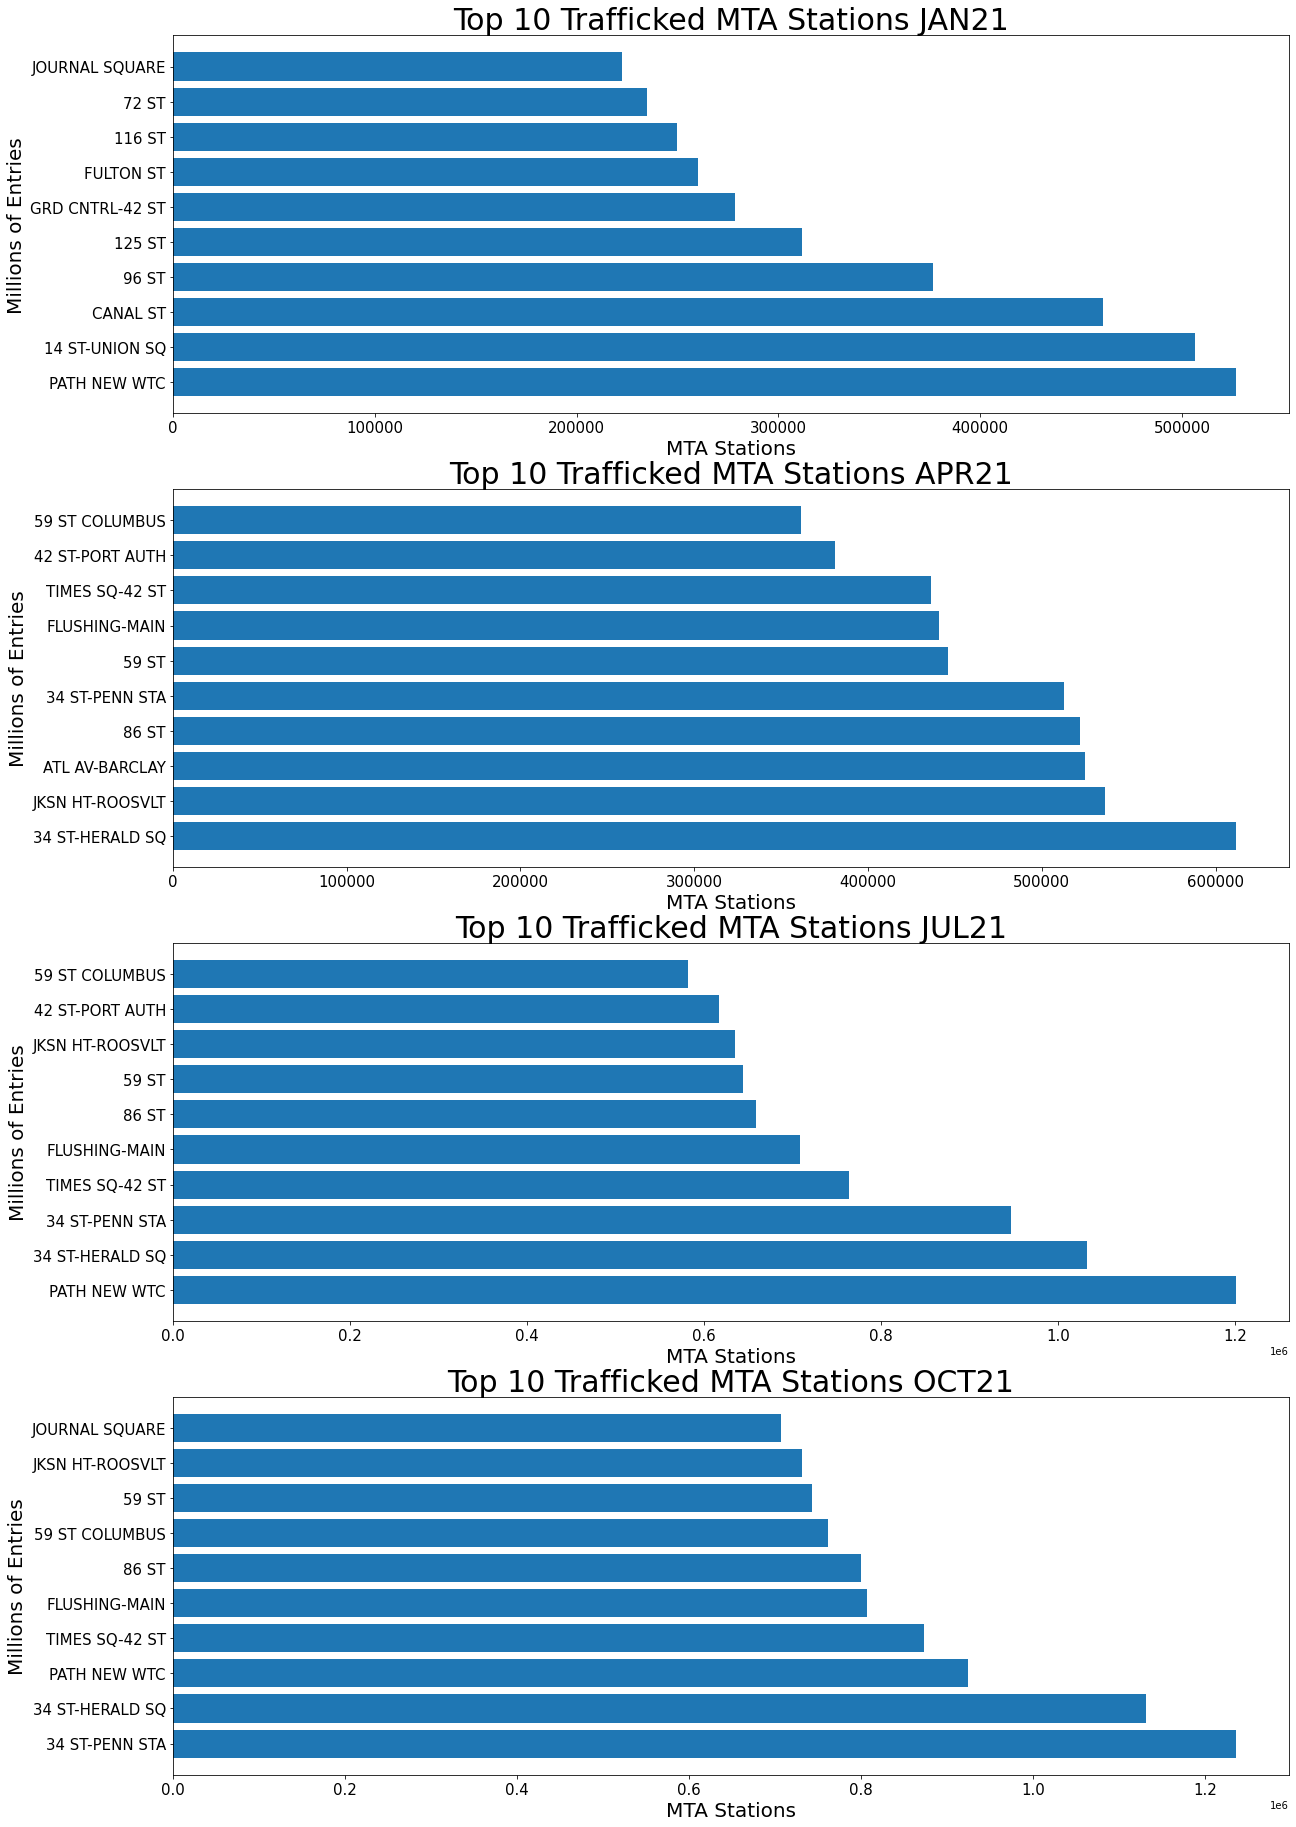

In [53]:
plt.figure(figsize = (20,32))
plt.subplot(4,1,1)
plt.barh(mta_jan_tot['STATION'], mta_jan_tot['DAILY_ENT'])
plt.title('Top 10 Trafficked MTA Stations JAN21', fontsize = 30)
plt.xlabel('MTA Stations', fontsize=20)
plt.ylabel('Millions of Entries', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(4,1,2)
plt.barh(mta_apr_tot['STATION'], mta_apr_tot['DAILY_ENT'])
plt.title('Top 10 Trafficked MTA Stations APR21', fontsize = 30)
plt.xlabel('MTA Stations', fontsize=20)
plt.ylabel('Millions of Entries', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(4,1,3)
plt.barh(mta_jul_tot['STATION'], mta_jul_tot['DAILY_ENT'])
plt.title('Top 10 Trafficked MTA Stations JUL21', fontsize = 30)
plt.xlabel('MTA Stations', fontsize=20)
plt.ylabel('Millions of Entries', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(4,1,4)
plt.barh(mta_oct_tot['STATION'], mta_oct_tot['DAILY_ENT'])
plt.title('Top 10 Trafficked MTA Stations OCT21', fontsize = 30)
plt.xlabel('MTA Stations', fontsize=20)
plt.ylabel('Millions of Entries', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('all_mta_traffic.jpg')

In [35]:
mta_jul_top3 = mta_jul_tot.drop(mta_jul_tot.index[3:], inplace = False)
mta_oct_top3 = mta_oct_tot.drop(mta_oct_tot.index[3:], inplace = False)

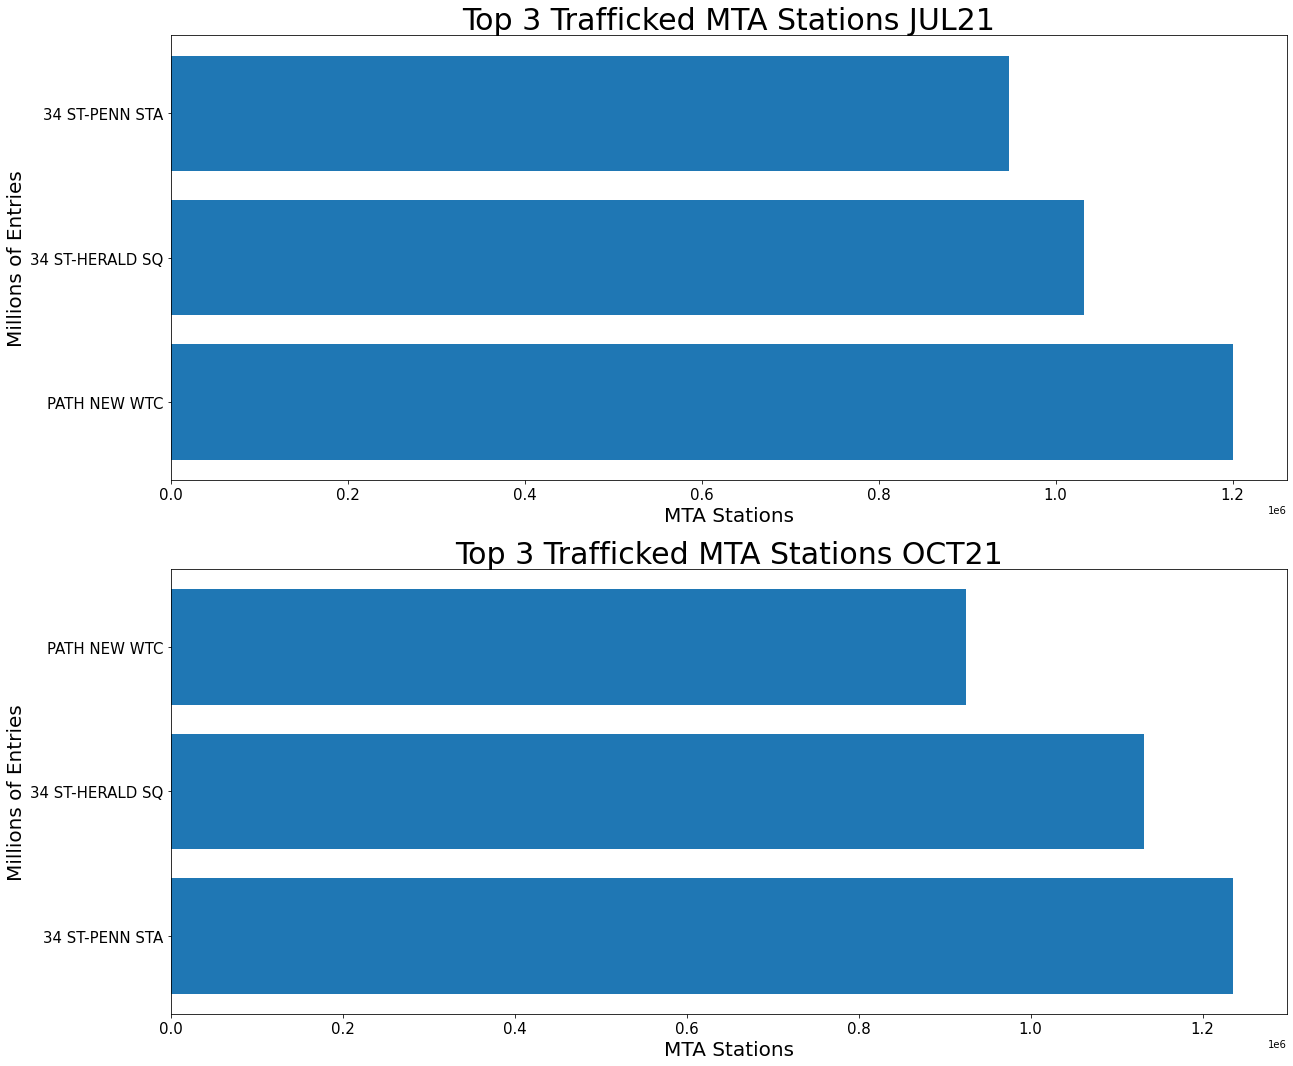

In [55]:
plt.figure(figsize = (20,18))

plt.subplot(2,1,1)
plt.barh(mta_jul_top3['STATION'], mta_jul_top3['DAILY_ENT'])
plt.title('Top 3 Trafficked MTA Stations JUL21', fontsize = 30)
plt.xlabel('MTA Stations', fontsize=20)
plt.ylabel('Millions of Entries', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,1,2)
plt.barh(mta_oct_top3['STATION'], mta_oct_top3['DAILY_ENT'])
plt.title('Top 3 Trafficked MTA Stations OCT21', fontsize = 30)
plt.xlabel('MTA Stations', fontsize=20)
plt.ylabel('Millions of Entries', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('jul_oct_mta_traffic.jpg')

In [37]:
mta_maint_df = pd.read_csv('MTA Maintenance Logs.csv')
mta_maint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     194 non-null    object
 1   Subject  194 non-null    object
 2   Message  194 non-null    object
dtypes: object(3)
memory usage: 4.7+ KB


In [38]:
mta_maint_df['Date'] = pd.to_datetime(mta_maint_df['Date'], infer_datetime_format = True)
mta_maint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     194 non-null    datetime64[ns]
 1   Subject  194 non-null    object        
 2   Message  194 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 4.7+ KB


In [39]:
print(mta_maint_df.Date.min())
print(mta_maint_df.Date.max())

2021-10-18 00:00:00
2021-10-29 00:00:00


In [40]:
'''34th ST-PENN STA, 34TH ST-HERALD SQ, PATH NEW WTC, top 3 for JUL & OCT'''
sta1 = mta_maint_df.loc[mta_maint_df['Message'].str.contains('PENN STA', case=False)]
sta2 = mta_maint_df.loc[mta_maint_df['Message'].str.contains('HERALD SQ', case=False)]
sta3 = mta_maint_df.loc[mta_maint_df['Message'].str.contains('PATH NEW WTC', case=False)]
sta_lst = [sta1['Date'].count(), sta2['Date'].count(), sta3['Date'].count()]
print(sta_lst)
nam_lst = ['34th ST-PENN STA', '34TH ST-HERALD SQ', 'PATH NEW WTC']

[0, 6, 0]


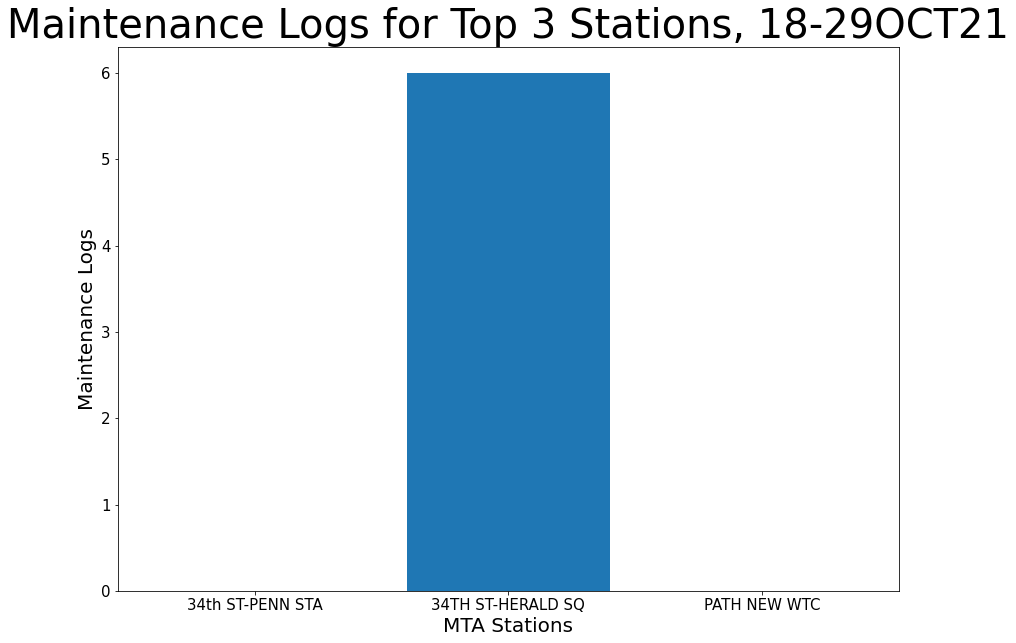

In [49]:
plt.figure(figsize = (14,10))
plt.bar(nam_lst, sta_lst)
plt.title('Maintenance Logs for Top 3 Stations, 18-29OCT21', fontsize = 40)
plt.xlabel('MTA Stations', fontsize = 20)
plt.xticks(fontsize=15)
plt.ylabel('Maintenance Logs', fontsize = 20)
plt.yticks(fontsize=15)
plt.savefig('mta_maint_log.jpg')

In [43]:
'''histogram of all station and their ridership in october'''

mta_oct_tot_v2 = (mta_oct.groupby('STATION')[['DAILY_ENT']].sum()
               .sort_values(by=['DAILY_ENT'], ascending = False)
               .reset_index())
mta_oct_tot_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STATION    232 non-null    object 
 1   DAILY_ENT  232 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.8+ KB


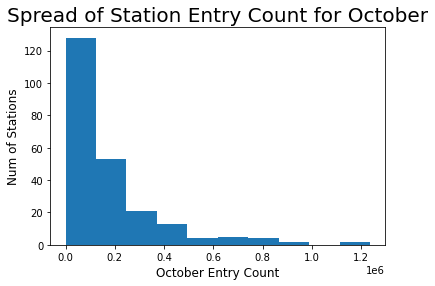

In [45]:

plt.hist(mta_oct_tot_v2['DAILY_ENT'])
plt.title('Spread of Station Entry Count for October', fontsize = 20)
plt.xlabel('October Entry Count')
plt.ylabel('Num of Stations')
plt.savefig('station_entry_count_histo.jpg')

In [46]:
mta_oct_tot_v2.describe()

,DAILY_ENT
count,2.320000e+02
mean,1.829200e+05
std,1.985280e+05
min,0.000000e+00
25%,6.817725e+04
50%,1.090085e+05
75%,1.955802e+05
max,1.235864e+06


In [47]:
print(mta_oct_tot_v2.DAILY_ENT.max())
print(mta_oct_tot_v2.DAILY_ENT.min())

1235864.0
0.0
